In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from copy import deepcopy

In [2]:
train_df = pd.read_csv('data/bert-mlp-elastic-train.csv')
test_df = pd.read_csv('data/bert-mlp-elastic-test.csv')

In [3]:
train_df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
test_df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [4]:
# drop neutral rows
train_df = train_df[train_df.label != 27]
test_df = test_df[test_df.label != 27]

In [5]:
train_df.sample(5)

,id,0,1,2,3,4,5,6,7,8,...,759,760,761,762,763,764,765,766,767,label
16986,16986,0.509639,0.138009,0.235104,0.103416,-0.267216,-0.299630,0.738355,0.312327,-0.229334,...,0.505332,-0.577954,0.457305,-0.156229,-0.050588,0.019829,-0.097903,0.957123,0.255097,17
22315,22315,0.406016,0.053632,-0.263439,-0.335910,-0.102837,-0.235194,0.204027,0.061984,0.006462,...,0.145323,-0.091707,-0.217597,0.063070,0.379022,0.176706,0.004723,0.387807,0.208718,4
9002,9002,0.597896,0.353557,0.199259,0.151702,0.013872,-0.083499,0.136693,-0.126075,-0.096364,...,0.272283,-0.008264,-0.140990,0.065319,0.241708,0.534747,-0.353143,0.175373,0.188764,15
4671,4671,0.272371,0.246834,-0.055307,-0.264491,-0.264151,-0.208428,0.171819,-0.194714,-0.000774,...,0.233682,-0.063023,0.182251,0.263910,0.253554,-0.377074,-0.479523,-0.099959,-0.150008,26
14894,14894,0.489200,0.040201,-0.115412,-0.328419,-0.302944,-0.276168,0.246019,-0.312727,0.124687,...,0.219028,-0.213292,-0.243797,0.058637,0.270176,-0.274597,-0.026289,-0.107207,-0.052429,7


In [6]:
test_df.sample(5)

,id,0,1,2,3,4,5,6,7,8,...,759,760,761,762,763,764,765,766,767,label
1402,1402,0.190307,0.106675,0.281058,-0.224696,-0.014316,-0.031437,-0.091776,-0.026028,0.200654,...,0.389718,-0.333324,-0.037347,-0.169950,0.520853,0.170349,0.007428,0.066859,-0.208091,9
333,333,0.355329,0.277012,-0.230934,-0.402007,-0.058719,-0.180732,0.087237,-0.199516,0.243705,...,0.214664,-0.318191,-0.253339,-0.041718,0.377419,-0.090491,-0.171495,0.077340,0.034959,10
2800,2800,0.358767,0.027173,-0.384696,-0.552144,-0.350741,0.056350,0.183596,0.210530,-0.133953,...,0.242923,-0.334138,-0.025182,0.165951,0.133650,-0.034765,-0.193509,0.602696,-0.017219,18
1514,1514,0.488547,0.358100,0.125918,-0.030607,0.015840,-0.036431,0.150694,-0.081794,-0.038110,...,0.256134,-0.012962,-0.221618,0.071015,0.173322,0.501892,-0.246970,0.269970,0.167191,15
100,100,0.417893,0.179481,-0.289462,-0.392151,-0.146330,-0.318731,0.095434,-0.342864,0.184233,...,0.001399,-0.272990,-0.227348,0.055218,0.340887,-0.106785,-0.090117,0.074888,0.077428,4


In [7]:
train_df.shape, test_df.shape

((23485, 770), (2984, 770))

In [8]:
train_df.isna().sum().sum()

0

In [9]:
class MakeDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.FloatTensor(X.values)
        self.labels = torch.LongTensor(y.values)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [10]:
X = train_df.iloc[:, 1:-1]
y = train_df.iloc[:, -1]

In [11]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
2,0.160260,0.615770,0.196324,-0.055271,0.248824,0.135621,0.187389,-0.116022,0.339001,-1.198854,...,0.148727,0.495772,0.334843,-0.192038,-0.036761,-0.047609,-0.264339,-0.125484,0.082188,-0.352742
3,0.015814,0.434408,0.394580,-0.049559,-0.495131,-0.012361,0.410473,-0.298084,-0.027932,-0.920122,...,-0.433667,0.358311,0.270823,-0.473695,0.422166,1.239002,-0.072179,-0.298189,0.167945,-0.439318
4,0.323881,0.459780,0.080875,-0.415690,0.020655,-0.302568,0.307698,-0.279703,-0.018415,-1.328160,...,-0.036822,0.307849,-0.104351,-0.519625,0.157718,-0.153203,-0.292116,0.142546,0.342701,-0.127562
5,0.357512,-0.214211,0.454459,-0.407095,-0.213990,-0.866075,0.378171,-0.136781,-0.631580,-1.290767,...,-0.046918,0.615718,0.081002,0.407675,-0.180611,0.009000,-0.170061,-0.547717,-0.226106,0.287012
6,0.498775,0.313840,0.017510,0.088427,0.038814,-0.127276,0.306921,-0.132979,-0.052126,-0.874871,...,0.274796,0.254025,0.079468,-0.150691,0.105731,0.148683,0.394337,-0.143627,0.273819,0.177476


In [12]:
X_test = test_df.iloc[:, 1:-1]
y_test = test_df.iloc[:, -1]

In [13]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.440630,0.273117,0.092668,-0.081169,0.187688,-0.081071,-0.156740,-0.039489,-0.000975,-0.415446,...,-0.193380,-0.095685,0.024948,0.013750,0.351269,0.593067,0.644927,0.010206,0.166739,0.033209
1,0.451050,0.261739,-0.196036,-0.326816,0.011206,-0.266389,0.147638,-0.124681,-0.032063,-1.150166,...,0.051832,0.379469,-0.384375,0.035980,0.177905,-0.034790,-0.212471,-0.159538,0.443314,-0.250951
2,0.599491,0.194527,-0.215783,0.036943,0.085576,0.229033,0.396423,0.167623,-0.338982,-0.917568,...,0.948445,0.195596,-0.150334,-0.390685,0.002389,0.300307,0.155793,-0.006989,0.642847,0.332788
3,0.450243,0.305356,0.092011,0.056187,-0.011086,-0.031766,0.031559,-0.122857,-0.128588,-0.936990,...,0.161616,0.305066,0.128358,-0.111276,0.161322,0.249234,0.452141,-0.293606,0.093173,0.180352
5,0.338573,0.344070,-0.038160,-0.032986,0.010184,0.033984,0.180147,-0.142813,-0.059671,-1.101200,...,0.129045,0.272048,-0.012292,-0.137306,0.193002,0.264374,0.359010,-0.252709,0.153023,0.220588


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=np.arange(768))
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=np.arange(768))

In [15]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-1.315281,2.018412,1.136636,1.024639,1.838479,1.214168,0.108802,-0.282535,1.756836,-0.538775,...,-0.009620,1.367566,2.943207,-0.364600,-1.396251,-0.993665,-0.994619,0.182504,-0.821489,-1.627990
1,-2.198029,1.059774,2.096811,1.058156,-1.977109,0.465256,1.403077,-1.249382,-0.156463,0.628854,...,-1.880320,0.458096,2.575027,-1.585757,2.108605,3.877324,-0.356567,-1.061143,-0.524987,-2.057498
2,-0.315357,1.193884,0.577507,-1.090065,0.668245,-1.003434,0.806803,-1.151773,-0.106838,-1.080447,...,-0.605620,0.124227,0.417387,-1.784890,0.089002,-1.393434,-1.086851,2.112576,0.079228,-0.510857
3,-0.109829,-2.368667,2.386811,-1.039631,-0.535201,-3.855247,1.215674,-0.392774,-3.304059,-0.923803,...,-0.638050,2.161156,1.483356,2.235520,-2.494844,-0.779349,-0.681576,-2.857990,-1.887404,1.545874
4,0.753462,0.422479,0.270623,1.867771,0.761381,-0.116311,0.802298,-0.372585,-0.282619,0.818412,...,0.395324,-0.231888,1.474535,-0.185336,-0.308027,-0.250520,1.192466,0.051857,-0.158929,1.002460


In [16]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.398126,0.207229,0.634620,0.872687,1.524923,0.117529,-1.887746,0.123900,-0.015902,2.742977,...,-1.108497,-2.545651,1.160992,0.527616,1.567165,1.431874,2.024530,1.159601,-0.529155,0.286742
1,0.461807,0.147087,-0.763605,-0.568606,0.619783,-0.820336,-0.121826,-0.328518,-0.178003,-0.334816,...,-0.320854,0.598078,-1.193044,0.623996,0.243168,-0.945132,-0.822396,-0.062719,0.427093,-1.122995
2,1.368961,-0.208180,-0.859243,1.565694,1.001214,1.686910,1.321563,1.223775,-1.778370,0.639550,...,2.559142,-0.618469,0.152935,-1.225859,-1.097263,0.323511,0.400397,1.035782,1.116972,1.772971
3,0.456873,0.377635,0.631437,1.678607,0.505452,0.367050,-0.795286,-0.318834,-0.681313,0.558194,...,0.031779,0.105809,1.755706,-0.014449,0.116523,0.130154,1.384399,-1.028144,-0.783509,1.016730
4,-0.225567,0.582271,0.001008,1.155396,0.614540,0.699802,0.066787,-0.424810,-0.321960,-0.129696,...,-0.072840,-0.112642,0.946821,-0.127303,0.358469,0.187474,1.075164,-0.733645,-0.576578,1.216343


In [17]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train,test in splitter.split(X,y):
    X_train = X.iloc[train]
    y_train = y.iloc[train]
    X_valid = X.iloc[test]
    y_valid = y.iloc[test]

print(y_train.value_counts())  
print(y_valid.value_counts())

label
0     2439
4     1686
15    1671
1     1487
3     1306
18    1284
10    1262
7     1250
2      922
20     775
6      772
17     768
25     735
26     648
9      638
5      584
22     527
13     459
11     448
14     387
8      350
24     318
12     183
23      79
19      77
21      46
16      35
Name: count, dtype: int64
label
0     271
4     187
15    186
1     165
3     145
18    143
10    140
7     139
2     103
6      86
20     86
17     85
25     82
26     72
9      71
5      65
22     59
13     51
11     50
14     43
8      39
24     35
12     20
23      9
19      8
21      5
16      4
Name: count, dtype: int64


In [18]:
class EmotionClassifier(nn.Module):
    def __init__(self, input_features, num_classes, drop_out_rate=0.5):
        super(EmotionClassifier, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_features, 384),
            nn.ReLU(),
            nn.BatchNorm1d(384),
            nn.Dropout(p=drop_out_rate),
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(p=drop_out_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=drop_out_rate),
            nn.Linear(128, num_classes),
        )
        
    def forward(self, x):
        x = self.layers(x)
        return x

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [20]:
# Set hyperparameters
input_features = 768
num_classes = 27
batch_size = 64
learning_rate = 0.0005

In [21]:
# Create model, loss function, optimizer, scheduler
model = EmotionClassifier(input_features, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [22]:
train_dataset = MakeDataset(X_train, y_train)
valid_dataset = MakeDataset(X_valid, y_valid) 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Training loop
num_epochs = 50
min_loss = 1e8
best_model = None
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_total = 0
    train_correct = 0
    
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, train_predicted = torch.max(outputs.data, 1)
        train_total += batch_labels.size(0)
        train_correct += (train_predicted == batch_labels).sum().item()
        train_accuracy = 100 * train_correct / train_total
        
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():    
        for batch_features, batch_labels in valid_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
    
    train_loss /= len(train_loader)
    val_loss /= len(valid_loader)
    accuracy = 100 * correct / total

    if val_loss < min_loss:
        min_loss = val_loss
        best_model = deepcopy(model)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")
    
    scheduler.step(val_loss)

Epoch [1/50], Train Loss: 0.9238, Train Accuracy: 76.54%, Val Loss: 0.3920, Val Accuracy: 88.21%
Epoch [2/50], Train Loss: 0.4796, Train Accuracy: 85.80%, Val Loss: 0.3539, Val Accuracy: 88.89%
Epoch [3/50], Train Loss: 0.4366, Train Accuracy: 87.44%, Val Loss: 0.3409, Val Accuracy: 89.57%
Epoch [4/50], Train Loss: 0.4138, Train Accuracy: 87.85%, Val Loss: 0.3400, Val Accuracy: 89.36%
Epoch [5/50], Train Loss: 0.3916, Train Accuracy: 88.24%, Val Loss: 0.3426, Val Accuracy: 89.36%
Epoch [6/50], Train Loss: 0.3771, Train Accuracy: 88.55%, Val Loss: 0.3482, Val Accuracy: 89.36%
Epoch [7/50], Train Loss: 0.3692, Train Accuracy: 88.82%, Val Loss: 0.3406, Val Accuracy: 89.91%
Epoch [8/50], Train Loss: 0.3668, Train Accuracy: 88.82%, Val Loss: 0.3436, Val Accuracy: 89.95%
Epoch [9/50], Train Loss: 0.3500, Train Accuracy: 89.26%, Val Loss: 0.3345, Val Accuracy: 89.70%
Epoch [10/50], Train Loss: 0.3403, Train Accuracy: 89.74%, Val Loss: 0.3346, Val Accuracy: 90.12%
Epoch [11/50], Train Loss: 0.

In [24]:
model = best_model

In [25]:
# Final test
model = model.to(device)
model.eval()
correct = 0
total = 0
with torch.inference_mode():
    for batch_features, batch_labels in valid_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

print(f'Final Accuracy on validation data: {100 * correct / total:.2f}%')

Final Accuracy on validation data: 89.87%


In [26]:
# Dataset for unlabeled test data
class MakeUnlabeledDataset(Dataset):
    def __init__(self, features):
        self.features = torch.FloatTensor(features)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx]

In [27]:
test_dataset = MakeUnlabeledDataset(X_test.values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
# Make predictions
final_predictions = []
with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features.to(device)
        outputs = model(batch_features)
        _, predicted = torch.max(outputs.data, 1)
        final_predictions.extend(predicted.cpu().numpy())

In [29]:
y_pred = np.array(final_predictions)
y_test = np.array(y_test)

In [30]:
total = len(y_test)
correct = np.sum(y_pred == y_test)
print(f'Final Accuracy on test data: {100 * correct / total:.2f}%')

Final Accuracy on test data: 57.71%


In [31]:
y_train.value_counts(), pd.Series(y_test).value_counts()

(label
 0     2439
 4     1686
 15    1671
 1     1487
 3     1306
 18    1284
 10    1262
 7     1250
 2      922
 20     775
 6      772
 17     768
 25     735
 26     648
 9      638
 5      584
 22     527
 13     459
 11     448
 14     387
 8      350
 24     318
 12     183
 23      79
 19      77
 21      46
 16      35
 Name: count, dtype: int64,
 0     348
 15    260
 4     236
 10    195
 3     194
 1     186
 7     176
 18    160
 2     131
 20    107
 25    102
 6      97
 17     93
 22     89
 9      88
 26     87
 5      86
 11     76
 14     65
 13     57
 8      56
 24     44
 12     23
 19     12
 21      7
 23      7
 16      2
 Name: count, dtype: int64)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [33]:
emotions_list = [
    'admiration',
    'amusement',
    'anger',
    'annoyance',
    'approval',
    'caring',
    'confusion',
    'curiosity',
    'desire',
    'disappointment',
    'disapproval',
    'disgust',
    'embarrassment',
    'excitement',
    'fear',
    'gratitude',
    'grief',
    'joy',
    'love',
    'nervousness',
    'optimism',
    'pride',
    'realization',
    'relief',
    'remorse',
    'sadness',
    'surprise',
    'neutral']

In [34]:
class_names = emotions_list[:-1]

In [35]:
print(classification_report(y_test, y_pred, target_names=class_names, zero_division=1))

                precision    recall  f1-score   support

    admiration       0.77      0.66      0.71       348
     amusement       0.84      0.85      0.84       186
         anger       0.68      0.38      0.49       131
     annoyance       0.38      0.33      0.35       194
      approval       0.37      0.63      0.46       236
        caring       0.68      0.33      0.44        86
     confusion       0.46      0.45      0.46        97
     curiosity       0.73      0.60      0.66       176
        desire       0.69      0.36      0.47        56
disappointment       0.37      0.33      0.35        88
   disapproval       0.49      0.56      0.52       195
       disgust       0.72      0.37      0.49        76
 embarrassment       0.62      0.57      0.59        23
    excitement       0.43      0.47      0.45        57
          fear       0.76      0.68      0.72        65
     gratitude       0.95      0.91      0.93       260
         grief       0.00      0.00      0.00  

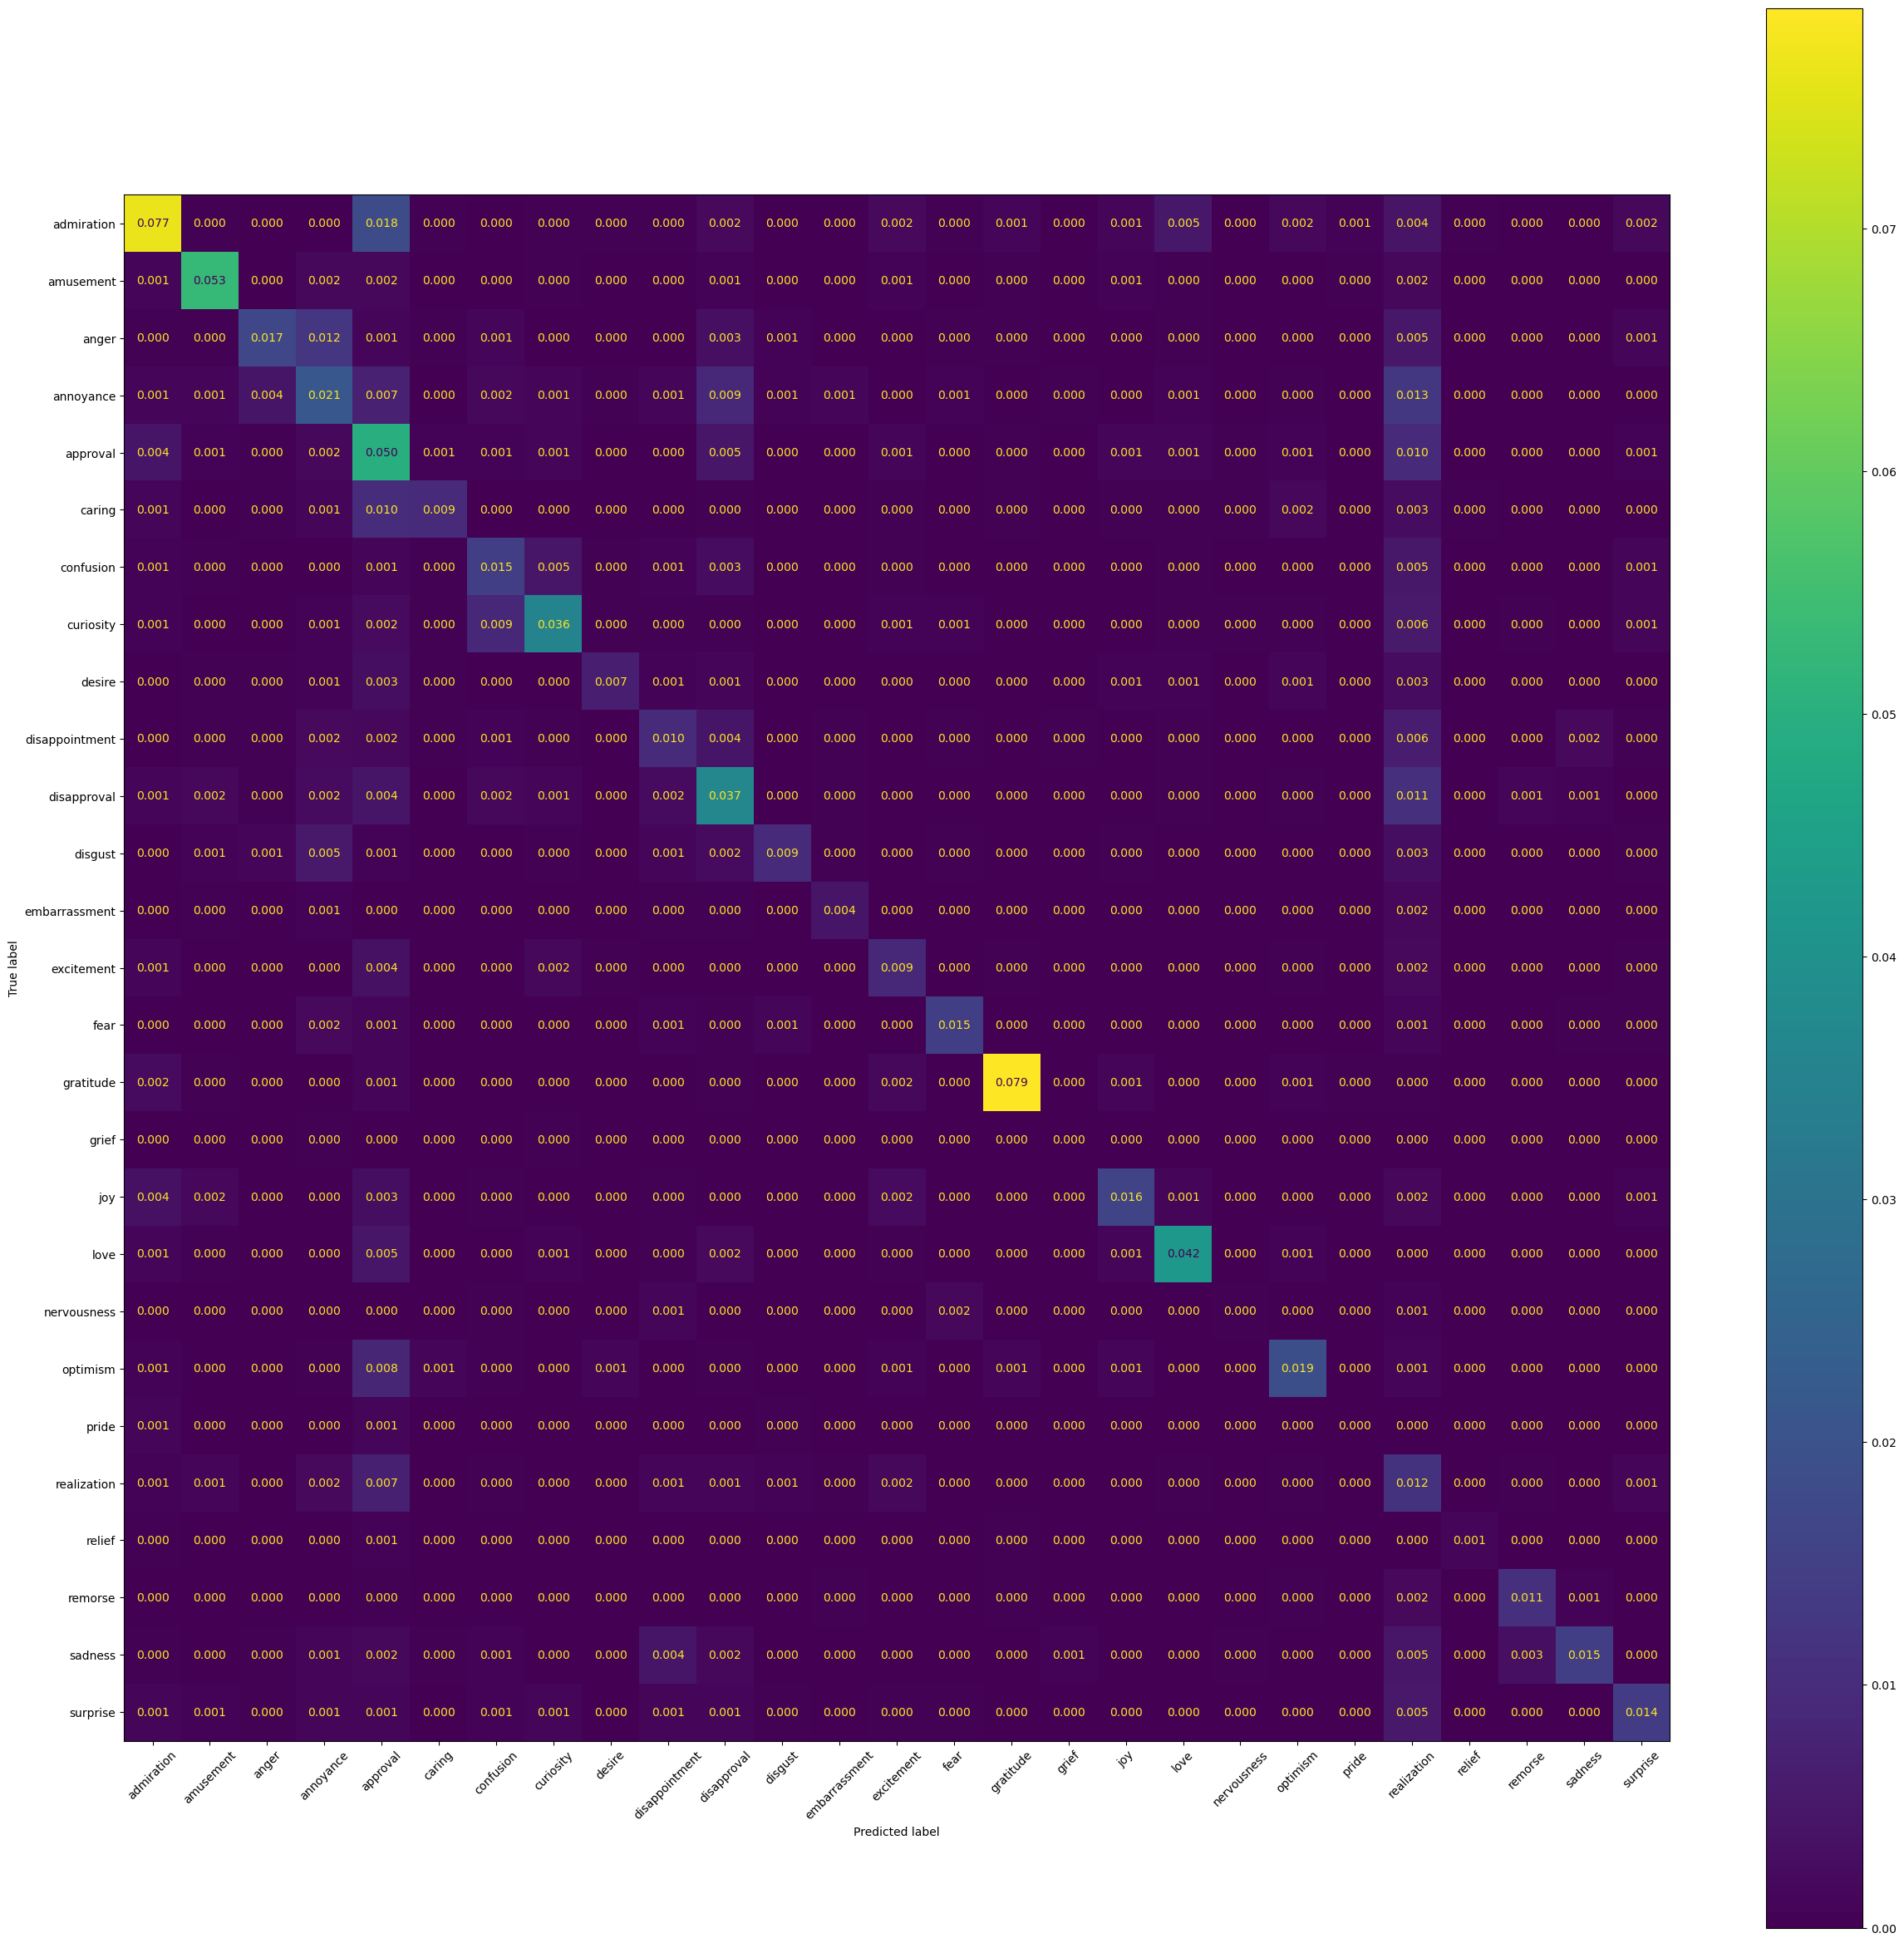

In [36]:
cm = confusion_matrix(y_test, y_pred, normalize='all')
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(30,30))
cmd.plot(ax=ax, values_format='.3f', xticks_rotation=45)

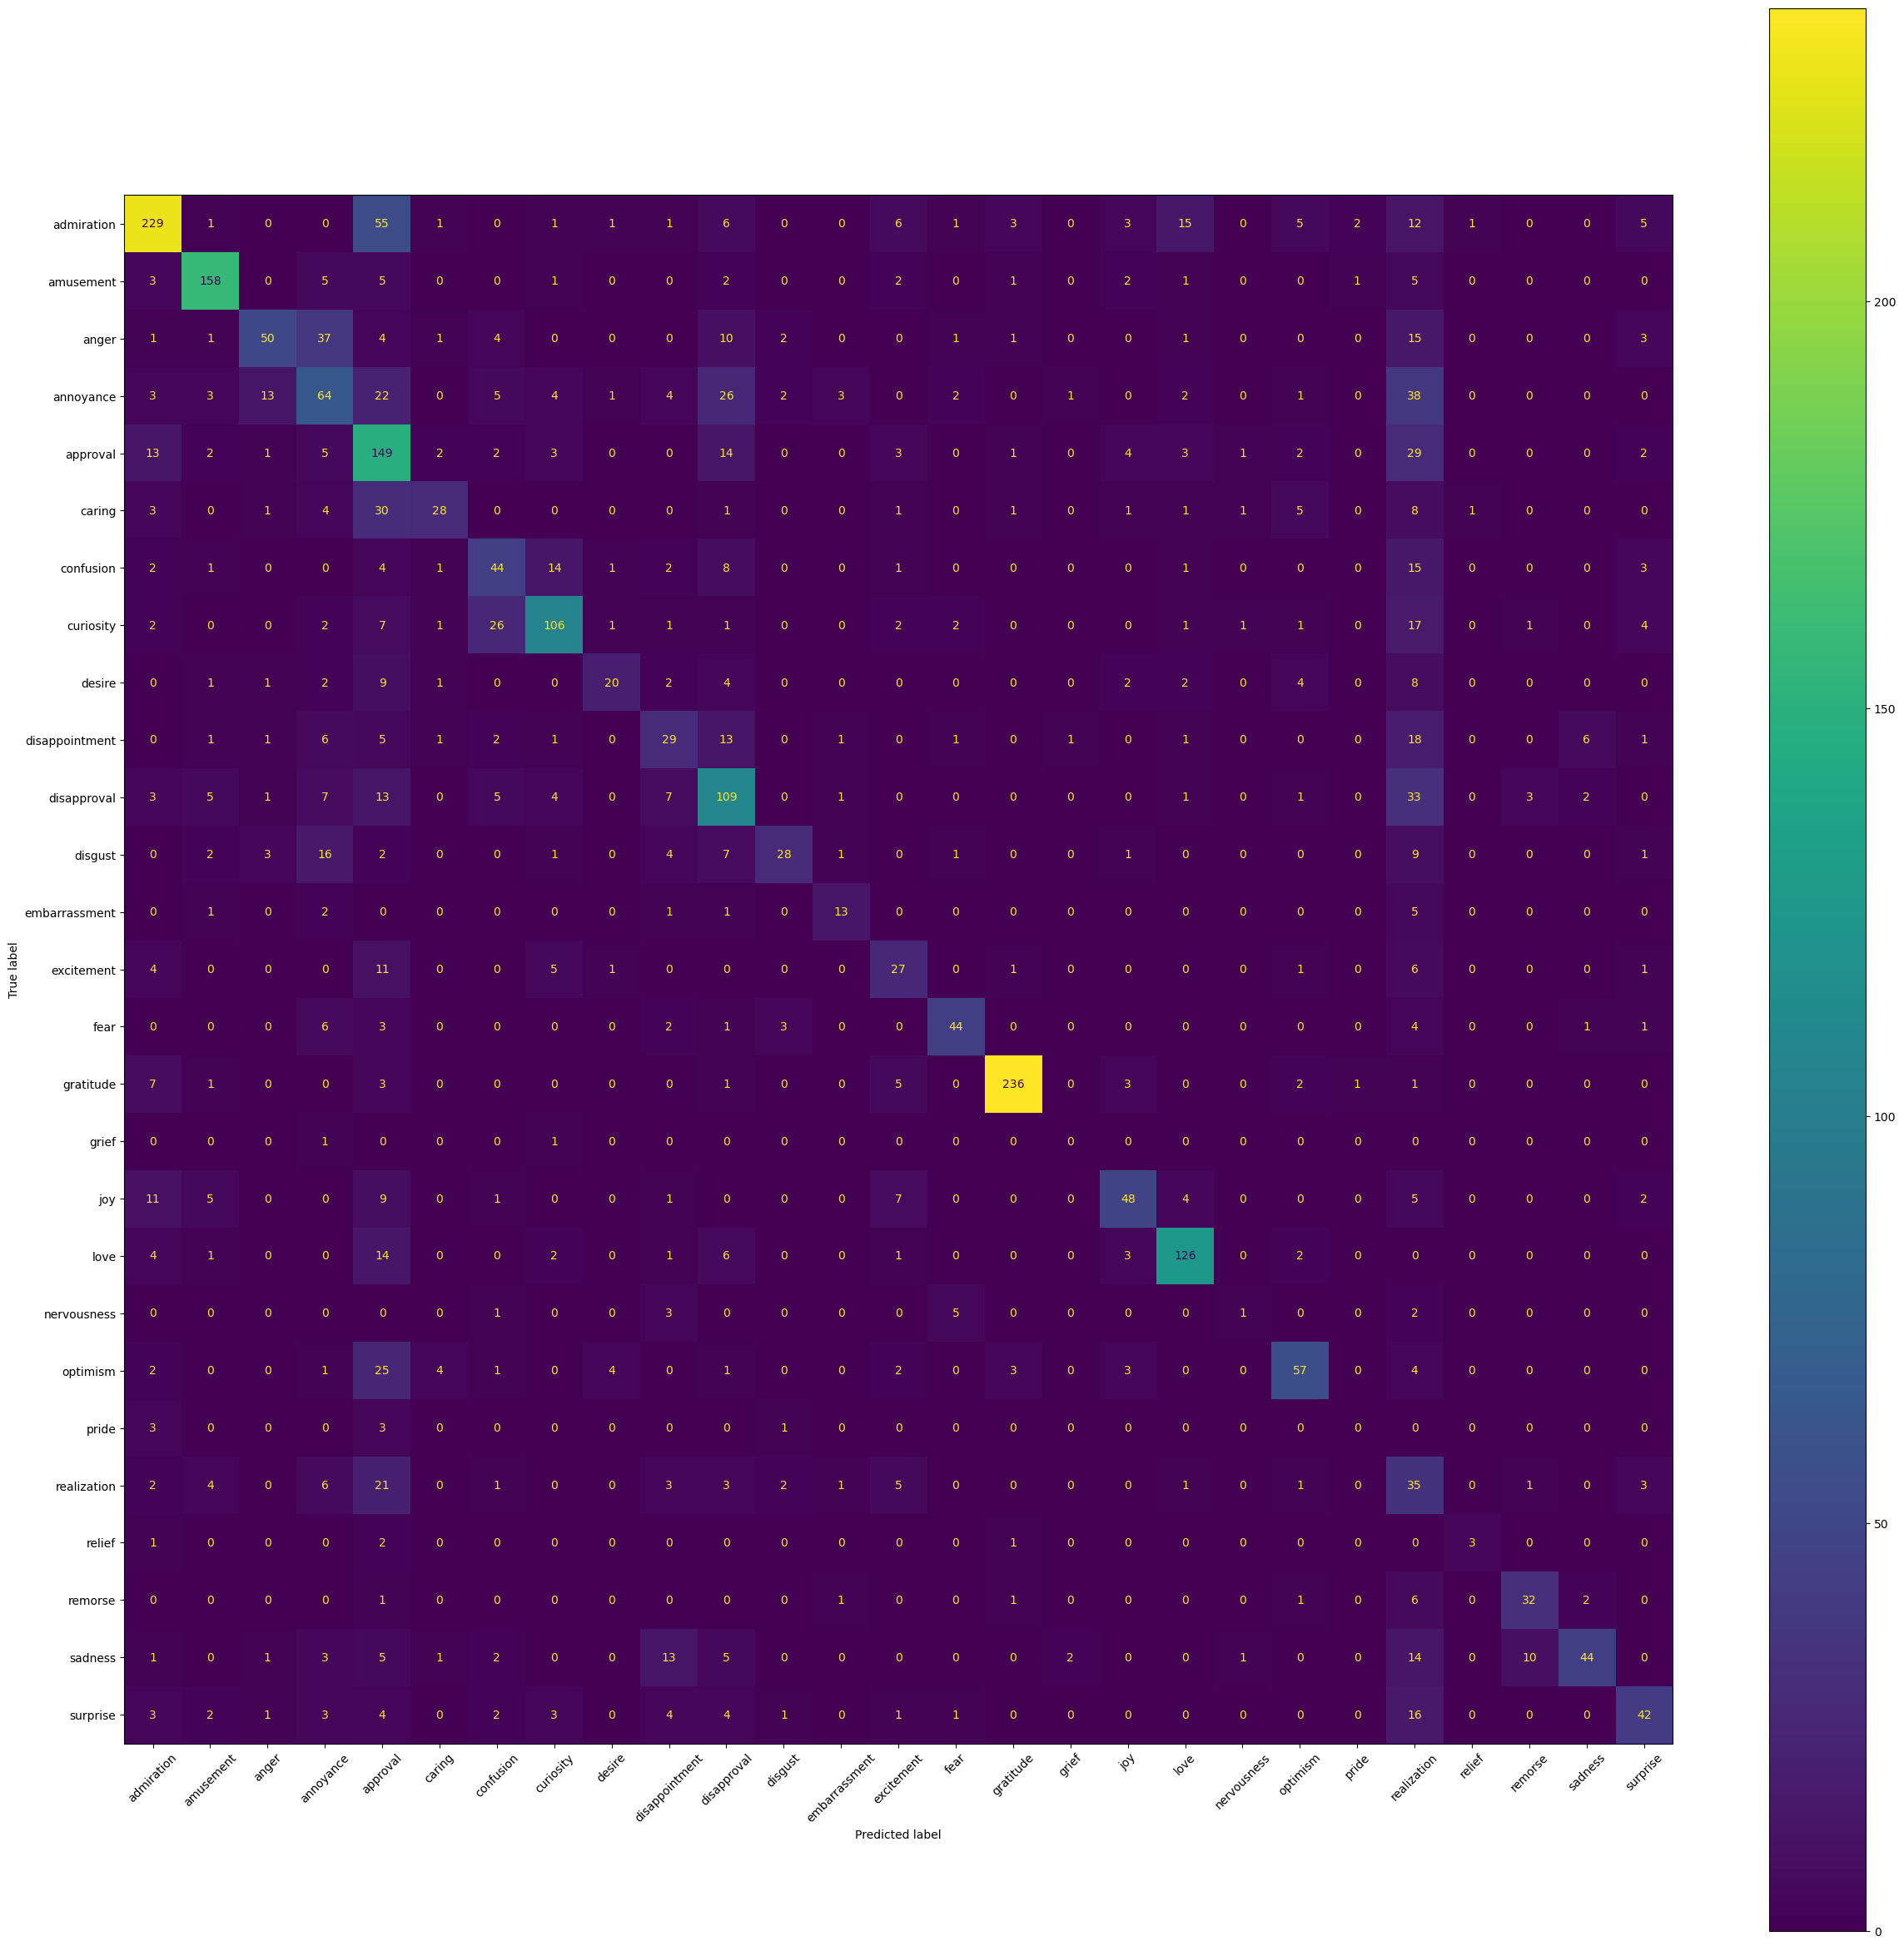

In [38]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(30,30))
cmd.plot(ax=ax, xticks_rotation=45)